In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from keras import layers, models, backend, optimizers, regularizers

In [2]:
print(tf.__version__)

2.9.1


In [64]:
# Train and Test Image Directories
train_img_dir = "D:Development/Data_Science_Datasets/Monkeypox_skinlesion/OriginalImages/"
test_img_dir = "D:Development/Data_Science_Datasets/Monkeypox_skinlesion/Test/"

# Basic variables
val_batch_size = 51
val_img_height = 56
val_img_width = 56
val_validation_split = None
val_subset = None
val_shuffle = False
val_labels = 'inferred'
val_label_mode = 'int'

In [65]:
train_img_ds = tf.keras.utils.image_dataset_from_directory(
    train_img_dir,
    validation_split = val_validation_split,
    subset = val_subset,
    seed=123,
    image_size=(val_img_height, val_img_width),
    batch_size = val_batch_size, 
    shuffle = val_shuffle,
    labels = val_labels,
    label_mode = val_label_mode)

Found 39168 files belonging to 2 classes.


In [66]:
test_img_ds = tf.keras.utils.image_dataset_from_directory(
    test_img_dir,
    validation_split = val_validation_split,
    subset = val_subset,
    seed=123,
    image_size=(val_img_height, val_img_width),
    batch_size = val_batch_size, 
    shuffle = val_shuffle,
    labels = val_labels,
    label_mode = val_label_mode)

Found 45 files belonging to 2 classes.


In [67]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [68]:
norm_train_img_ds = train_img_ds.map(lambda x, y: (normalization_layer(x), y))

In [69]:
class_names = train_img_ds.class_names
print(class_names)

['Monkeypox', 'Others']


In [70]:
norm_test_img_ds = test_img_ds.map(lambda x, y: (normalization_layer(x), y))

In [71]:
model = models.Sequential()
model.add(layers.Flatten(input_shape = (val_img_height, val_img_width, 3)))
model.add(layers.Dense(2048, activation='sigmoid'))
model.add(layers.Dense(768, activation='sigmoid'))
model.add(layers.Dense(2, activation = 'softmax'))

In [72]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 9408)              0         
                                                                 
 dense_3 (Dense)             (None, 2048)              19269632  
                                                                 
 dense_4 (Dense)             (None, 768)               1573632   
                                                                 
 dense_5 (Dense)             (None, 2)                 1538      
                                                                 
Total params: 20,844,802
Trainable params: 20,844,802
Non-trainable params: 0
_________________________________________________________________


In [79]:
STEPS_PER_EPOCH = 90

In [80]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(0.001, decay_steps = STEPS_PER_EPOCH, 
                                                             decay_rate=1, staircase=False)

In [81]:
optimizer = optimizers.Adam(lr_schedule)

In [78]:
callback = [tf.keras.callbacks.EarlyStopping(monitor='Sparse_CategoricalCrossentropy', patience=120)]

In [ ]:
model.compile(optimizer = optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.losses.SparseCategoricalCrossentropy(
                      from_logits=False, name='Sparse_CategoricalCrossentropy'), 'accuracy'])

#backend.set_value(model.optimizer.learning_rate, 0.0001)

history = model.fit(norm_train_img_ds,  epochs=15, 
                    validation_data=(norm_test_img_ds), batch_size = val_batch_size,
                   callbacks = callback)

Epoch 1/15
429/768 [===============>..............] - ETA: 45s - loss: 0.4002 - Sparse_CategoricalCrossentropy: 0.4002 - accuracy: 0.9441

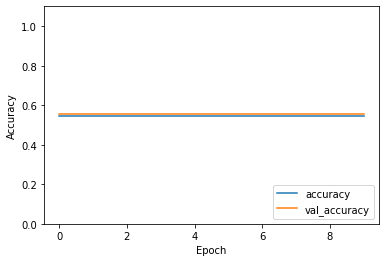

In [63]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.1])
plt.legend(loc='lower right')

In [ ]:
val_img_dir = "D:Development/Data_Science_Datasets/Monkeypox_skinlesion/Val/"

val_img_ds = tf.keras.utils.image_dataset_from_directory(
    val_img_dir,
    validation_split = val_validation_split,
    subset = val_subset,
    seed = 123,
    image_size=(val_img_height, val_img_width),
    batch_size = val_batch_size, 
    shuffle = val_shuffle,
    labels = val_labels,
    interpolation = 'gaussian')

In [ ]:
norm_val_img_ds = val_img_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
test_loss, test_acc = model.evaluate(val_img_ds,  verbose=2)
print(test_acc)

In [ ]:
test_loss, test_acc = model.evaluate(norm_val_img_ds,  verbose=2)
print(test_acc)